# For G Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/RL/'

In [5]:
%pip install -U gym[atari,accept-rom-license]==0.21.0
# %pip install tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


# Main

In [6]:
import gym
# import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from IPython import display
from collections import deque
import warnings
warnings.filterwarnings("ignore")

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "C:\Users\binda\anaconda3\python.exe"
  * The NumPy version is: "1.21.2"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.


In [2]:
env = gym.make('Breakout-v0')

NameError: name 'gym' is not defined

## Simulation

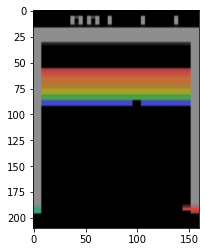

In [ ]:
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
score = 0
done = False
i = 0
while i < 1000 and not done:
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    obs, x, done, _ = env.step(action)
    score += x
    i += 1

## Random Data Generation

In [3]:
def image_compressor(img, new_size=(75, 80)):

    img_reduced = img[30:195, 5:155,:]
    img_grey = cv2.cvtColor(img_reduced, cv2.COLOR_BGR2GRAY)
    img_compressed = cv2.resize(img_grey, new_size)

    return img_compressed

In [4]:
cols = ['Obs'+str(i)+'_'+str(m)+'_'+str(n) for i in range(2) for m in range(80) for n in range(75)]
cols.extend(['action', 'reward'])

In [5]:
def list_to_pdSeries(keys, values):
    dic = {}
    for i in range(len(keys)):
        dic[keys[i]] = values[i]
    return pd.Series(dic)

In [6]:
episodes = 1000
life_memory = []
i_episode = 0
discount_factor = 0.9
stepper = True

while i_episode < episodes:
    episodic_memory = []
    done = False
    obss = deque(maxlen=2)
    obs = env.reset()
    ep_reward = 0
    prev_reward = 0
    for i in range(10):
        obss.append(image_compressor(obs))
        action = env.action_space.sample()
        obs, _, _, _ = env.step(action)
        obss.append(image_compressor(obs))
    
    while not done:
        step_memory = []
        stepper = not stepper
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        ep_reward = (reward - prev_reward)*10 + ep_reward*discount_factor
        if stepper:
            continue
        step_memory.extend(obss[0].flatten())
        step_memory.extend(obss[1].flatten())
        step_memory.extend([action, ep_reward])
        episodic_memory.append(list_to_pdSeries(keys=cols, values=step_memory))
        obss.append(image_compressor(obs))
        prev_reward = reward

    life_memory.extend(episodic_memory)
    i_episode += 1

memory_df = pd.concat(life_memory, axis=1).T

In [ ]:
memory_df.shape

(2347, 12002)

In [ ]:
memory_df.to_csv('random_data.csv', index=False)

In [ ]:
memory_df['reward'].sum()

## Training

In [1]:
from models import Model1
from helper_funcs import *
from tensorflow.keras import losses, optimizers, metrics
from sklearn.model_selection import train_test_split

In [2]:
model_ = Model1()
model = model_.model((80, 75, 3), 4)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 75, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 73, 5)         140       
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 73, 5)         20        
_________________________________________________________________
activation (Activation)      (None, 78, 73, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 71, 8)         368       
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 71, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 76, 71, 8)         0     

In [3]:
lr = 0.003
model.compile(optimizer=optimizers.RMSprop(learning_rate=lr), 
                loss=losses.MeanAbsoluteError(), 
                metrics=metrics.MeanAbsoluteError())

In [4]:
# path = 'D:/Projects/Atari breakout game DATA/'
# data = pd.read_csv(path + 'random_data.csv')

path = 'D:/Projects/Atari-Breakout-Game/'
data = pd.read_csv(path + 'data_processed2.csv')

In [5]:
data.shape

(11937, 12002)

In [6]:
Y = data['reward'].to_numpy()
actions = data['action'].to_numpy()
X = data.drop(columns=['reward', 'action']).to_numpy()

In [7]:
X = merge_S_A(X, actions)

In [8]:
X = np.reshape(X, newshape=((X.shape[0], 80, 75, 3)))

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

In [10]:
X_train.shape

(8355, 80, 75, 3)

In [11]:
model.fit(X_train, Y_train, epochs=8, batch_size=64)

Epoch 1/8
131/131 [==============================] - 15s 27ms/step - loss: 9.6092 - mean_absolute_error: 9.6092
Epoch 2/8
131/131 [==============================] - 3s 24ms/step - loss: 9.6092 - mean_absolute_error: 9.6092
Epoch 3/8
131/131 [==============================] - 3s 24ms/step - loss: 9.6092 - mean_absolute_error: 9.6092
Epoch 4/8
131/131 [==============================] - 3s 24ms/step - loss: 9.6092 - mean_absolute_error: 9.6092
Epoch 5/8
131/131 [==============================] - 3s 25ms/step - loss: 9.6092 - mean_absolute_error: 9.6092
Epoch 6/8
131/131 [==============================] - 3s 24ms/step - loss: 9.6092 - mean_absolute_error: 9.6092
Epoch 7/8
131/131 [==============================] - 3s 24ms/step - loss: 9.6092 - mean_absolute_error: 9.6092
Epoch 8/8
131/131 [==============================] - 3s 25ms/step - loss: 9.6092 - mean_absolute_error: 9.6092


In [12]:
model.evaluate(X_test, Y_test)

112/112 [==============================] - 13s 8ms/step - loss: 9.5656 - mean_absolute_error: 9.5656


[9.565617561340332, 9.565617561340332]

In [13]:
model.save('model2')

INFO:tensorflow:Assets written to: model2\assets


## Testing and Data Generation

In [17]:
from tensorflow.keras.models import load_model
from helper_funcs import *
model = load_model('model2')

In [18]:
cols = ['Obs'+str(i)+'_'+str(m)+'_'+str(n) for i in range(2) for m in range(80) for n in range(75)]
cols.extend(['action', 'reward'])

In [23]:
episodes = 100
life_memory = []
i_episode = 0
epsilon = .5
discount_factor = 0.9
stepper = True

while i_episode < episodes:
    episodic_memory = []
    done = False
    obss = deque(maxlen=2)
    obs = env.reset()
    ep_reward = 0
    prev_reward = 0
    for i in range(10):
        obss.append(image_compressor(obs))
        action = env.action_space.sample()
        obs, _, _, _ = env.step(action)
        obss.append(image_compressor(obs))
    
    while not done:
        step_memory = []
        stepper = not stepper
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(model.predict(model_input(obss[0], obss[1], 4)))
        obs, reward, done, info = env.step(action)
        ep_reward = (reward - prev_reward)*10 + ep_reward*discount_factor - 1
        if stepper:
            continue
        step_memory.extend(obss[0].flatten())
        step_memory.extend(obss[1].flatten())
        step_memory.extend([action, ep_reward])
        episodic_memory.append(list_to_pdSeries(keys=cols, values=step_memory))
        obss.append(image_compressor(obs))
        prev_reward = reward

    life_memory.extend(episodic_memory)
    i_episode += 1

memory_df = pd.concat(life_memory, axis=1).T

In [24]:
# memory_df = pd.concat(life_memory, axis=1).T
memory_df.shape

(11937, 12002)

In [25]:
memory_df['reward'].sum()

-114546.70369106122

In [26]:
memory_df.to_csv('data_processed2.csv', index=False)

KeyboardInterrupt: 

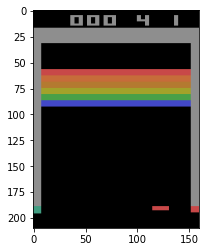

In [6]:
from collections import deque
import gym
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras.models import load_model
from helper_funcs import *

model = load_model('model2')
env = gym.make('Breakout-v0')
obss = deque(maxlen=2)
obs = env.reset()

for i in range(10):
    obss.append(image_compressor(obs))
    action = env.action_space.sample()
    obs, _, _, _ = env.step(action)
    obss.append(image_compressor(obs))

img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = np.argmax(model.predict(model_input(obss[0], obss[1], 4)))
    obs, x, done, _ = env.step(action)
    obss.append(image_compressor(obs))